# **10) Full pipeline testing**

In [1]:
from pathlib import Path
import os, sys, platform, warnings

ROOT = Path.cwd().resolve().parents[0]
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT))

print("Project root:", ROOT)
print("Python:", sys.version)
print("OS:", platform.platform())

Project root: D:\IIT BBS\Job Resources\fiolabs\diagram-intel
Python: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0


In [2]:
# Isolate to a throwaway workspace
os.environ["RUN_ID"] = "dev-new-mods-1"          # <- change per test
os.environ["CONSTRAINTS_PACKS"] = os.environ.get("CONSTRAINTS_PACKS","generic,indian_power")
os.environ["PROJECT_CONSTRAINTS"] = "suggested_wiring diagram_Main Distribution Panel_Fio Labs"

from src.config.loader import load_cfg
cfg = load_cfg()

print("WORKSPACE")
print("  raw      :", cfg.paths.raw)
print("  interim  :", cfg.paths.interim)
print("  processed:", cfg.paths.processed)
print("  exports  :", cfg.paths.exports)

WORKSPACE
  raw      : D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\raw
  interim  : D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\interim
  processed: D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed
  exports  : D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\exports


D:\IIT BBS\Job Resources\fiolabs\diagram-intel\src\config\loader.py:59: UserWarning: [loader] Hard merge failed for 'D:\IIT BBS\Job Resources\fiolabs\diagram-intel\configs\constraints\packs\generic.yaml' (ConfigTypeError); falling back to soft replace-on-mismatch.
  warnings.warn(f"[loader] Hard merge failed for '{p}' ({e.__class__.__name__}); "
D:\IIT BBS\Job Resources\fiolabs\diagram-intel\src\config\loader.py:59: UserWarning: [loader] Hard merge failed for 'D:\IIT BBS\Job Resources\fiolabs\diagram-intel\configs\constraints\projects\suggested_wiring diagram_Main Distribution Panel_Fio Labs.yaml' (ConfigTypeError); falling back to soft replace-on-mismatch.
  warnings.warn(f"[loader] Hard merge failed for '{p}' ({e.__class__.__name__}); "


In [3]:
from omegaconf import OmegaConf
con = cfg.constraints
print("Constraints keys:", list(con.keys()))
print("Rulebook:", list((con.get("rulebook") or {}).keys())[:20])
print("Inference:", list((con.get("inference") or {}).keys()))
print("Nets:", con.get("nets"))

Constraints keys: ['rulebook', 'net_rules', 'refine', 'nets', 'ports', 'snap', 'components', 'inference', 'name', 'doc', 'phases', 'neutral', 'protective', 'rules', 'vocabulary', 'colour_code']
Rulebook: ['MCCB_3P', 'MCCB_4P', 'MCB_1P', 'MCB_2P', 'MCB_3P', 'MCB_4P', 'ISOLATOR_2P', 'ISOLATOR_4P', 'RCCB_2P', 'RCCB_4P', 'SPD_4P', 'TPN_OUTGOING', 'TB_MULTI', 'ACCL_1PH', 'ACCL_3PH', 'THREEWAY_2P', 'MCCB_TP', 'MCCB_TPN', 'CONTACTOR_3P']
Inference: ['enable', 'source_keywords', 'load_keywords', 'typing_hints_contains', 'ratings_regex']
Nets: {'max_nodes_warning': 5000, 'max_nodes_error': 15000}


In [4]:
from pathlib import Path
from src.ingest.pdf_to_svg import extract_svg
from src.ingest.tiler import tile_pages

inp_dir = Path(cfg.paths.input_pdfs)
pdfs = [p for p in inp_dir.glob("*") if p.suffix.lower()==".pdf"]
assert pdfs, "Put at least one PDF in data/input_pdfs/"
pdf_path = pdfs[0]
pdf_stem = pdf_path.stem

extract_svg(str(pdf_path), cfg)
tile_pages(cfg)

2025-08-27 20:14:20.292 | INFO     | src.ingest.pdf_to_svg:extract_svg:16 - [ingest] Exporting SVG/PNG for wiring diagram_Main Distribution Panel_Fio Labs.pdf (dpi=900)
2025-08-27 20:14:22.353 | INFO     | src.ingest.pdf_to_svg:extract_svg:30 - [ingest] Engine=pymupdf | pages=1 | vector-like pages=1
2025-08-27 20:14:22.353 | INFO     | src.ingest.pdf_to_svg:extract_svg:31 - [ingest] Wrote manifest → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\raw\manifests\wiring diagram_Main Distribution Panel_Fio Labs.json
2025-08-27 20:14:28.241 | INFO     | src.ingest.tiler:tile_pages:66 - [tiler] wiring diagram_Main Distribution Panel_Fio Labs page-1: wrote 602 tiles
2025-08-27 20:14:28.254 | INFO     | src.ingest.tiler:tile_pages:69 - [tiler] Wrote tile index (602 rows) → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\interim\tiles\tile_index.json


In [13]:
from src.vision.runners.labels_reader import build_vector_text_index, run_labels_reader
vec_idx = build_vector_text_index(cfg)
run_labels_reader(cfg)

2025-08-27 14:57:08.681 | INFO     | src.vision.runners.labels_reader:build_vector_text_index:158 - [vector_text] wiring diagram_Main Distribution Panel_Fio Labs: 260 items across 1 pages (sources: ['pymupdf'])
2025-08-27 14:57:08.697 | INFO     | src.vision.runners.labels_reader:run_labels_reader:195 - [labels] VLM disabled for micro tiles.
2025-08-27 14:57:08.697 | INFO     | src.vision.runners.labels_reader:run_labels_reader:198 - [labels] OCR fallback enabled (Donut) with min_vec_text_threshold=20
2025-08-27 16:36:44.664 | INFO     | src.vision.runners.labels_reader:run_labels_reader:274 - [labels] wrote 450 tile label files → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\labels\tile_labels.index.json


In [14]:
from src.vision.runners.symbol_classifier import classify_meso_tiles
from src.post.merge_candidates import run_merge

classify_meso_tiles(cfg)   # uses Qwen 2B by default (fastest CPU)
merge_stats = run_merge(cfg)
merge_stats

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Loading checkpoint shards: 100%|██████████| 2/2 [01:41<00:00, 50.69s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  

2025-08-27 19:53:00.804 | INFO     | src.vision.runners.symbol_classifier:classify_meso_tiles:175 - [symbols] wrote 60 candidates → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\components\candidates.index.json
2025-08-27 19:53:01.867 | INFO     | src.post.merge_candidates:run_merge:182 - [merge] wiring diagram_Main Distribution Panel_Fio Labs page-1: 60 → 4 merged components
2025-08-27 19:53:01.871 | INFO     | src.post.merge_candidates:run_merge:185 - [merge] wrote 4 entries → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\components\merged\merged.index.json


In [15]:
from src.geometry.wires import extract_wires_for_pdf
from src.geometry.ports import snap_wires_to_components
from src.utils.io import read_json
from pathlib import Path

extract_wires_for_pdf(cfg, pdf_stem)
snap_wires_to_components(cfg, pdf_stem)

ports_json = Path(cfg.paths.processed)/"ports"/pdf_stem/"page-1.json"
P = read_json(ports_json)
print("ports:", len(P["ports"]), "connections:", len(P["connections"]))

2025-08-27 19:54:11.073 | INFO     | src.geometry.wires:extract_wires_for_pdf:123 - [wires] wiring diagram_Main Distribution Panel_Fio Labs page-1: segs=1516 polys=1383 → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\wires\wiring diagram_Main Distribution Panel_Fio Labs\page-1.json
2025-08-27 19:54:12.728 | INFO     | src.geometry.ports:snap_wires_to_components:129 - [ports] wiring diagram_Main Distribution Panel_Fio Labs page-1: ports=2117 conns=2299 → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\ports\wiring diagram_Main Distribution Panel_Fio Labs\page-1.json
ports: 2117 connections: 2299


In [16]:
from src.stitching.build_nets import stitch_page
from src.utils.io import read_json
from pathlib import Path

G, nets_payload = stitch_page(cfg, pdf_stem, page=1)
print("nets:", nets_payload["count"])

gdir = Path(cfg.paths.processed)/"graphs"/pdf_stem
print("Graph JSON:", (gdir/"page-1.json").exists())
print("GraphML   :", (gdir/"page-1.graphml").exists(), "(install lxml if False)")


2025-08-27 19:54:57.395 | INFO     | src.graph.build_graph:build_graph_for_page:88 - [graph.build] nodes=4510 edges=5607
2025-08-27 19:54:57.919 | INFO     | src.stitching.build_nets:stitch_page:144 - [stitch] wiring diagram_Main Distribution Panel_Fio Labs page-1: nets=158 → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\nets\wiring diagram_Main Distribution Panel_Fio Labs\page-1.json
nets: 158
Graph JSON: True
GraphML   : True (install lxml if False)


In [17]:
from src.refine.violation_detector import detect_violations
from src.refine.recursive_refine import autofix_ports_on_edges

det = detect_violations(cfg, pdf_stem, page=1)
print("violations:", len(det["violations"]))
autofix = autofix_ports_on_edges(cfg, pdf_stem, page=1)
autofix

violations:2025-08-27 19:55:39.467 | INFO     | src.refine.violation_detector:detect_violations:230 - [refine] wrote violations → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\refine\wiring diagram_Main Distribution Panel_Fio Labs\page-1.violations.json
 0
2025-08-27 19:55:39.606 | INFO     | src.refine.recursive_refine:autofix_ports_on_edges:69 - [refine.autofix] moved 0 ports to bbox edges → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\graphs_refined\wiring diagram_Main Distribution Panel_Fio Labs\page-1.json


{'fixed': 0,
 'path': 'D:\\IIT BBS\\Job Resources\\fiolabs\\diagram-intel\\data\\_runs\\dev-new-mods-1\\processed\\graphs_refined\\wiring diagram_Main Distribution Panel_Fio Labs\\page-1.json'}

In [7]:
from src.summarize.component_summary import summarize_components, component_counts
cnts = component_counts(cfg, pdf_stem, page=1)
for k,v in sorted(cnts.items(), key=lambda kv:(-kv[1],kv[0])):
    print(f"{k}: {v}")

blurbs = summarize_components(cfg, pdf_stem, page=1, top_n=6)
for b in blurbs:
    print("-", b)

from src.schema.serialization import export_components_csv
out_csv = export_components_csv(cfg, pdf_stem, page=1)
print("CSV:", out_csv, Path(out_csv).exists())

Un-typed: 4
- Un-typed — phase=L1/L2/L3/N volt=- bbox=7044x3962 | labels: 1 3 | 125G | 151G | 152G | 154G | MCB4  32A | TPN2 63A | To | TPN3 63A | MCB5  32A | 155G | 157G | 1…
- Un-typed — phase=L1/L2/L3/N volt=- bbox=7984x1894 | labels: N 1 3 | N 2 4 | 4 6 | 20G | 55G | 57G | 70G | 122G | 124G | 121G | 125G | 142G | RCCB1 40A 100mA | I…
- Un-typed — phase=L1/L2/L3/N volt=- bbox=2764x4832 | labels: 1 3 | 14K | MCCB1 100A | From Meter | From PV Inverter | TB1 CTS35L | 15K | 17K | 20K | 14G | 15G | …
- Un-typed — phase=L1/L2/L3/N volt=- bbox=954x1024 | labels: REFERNCE CABLE | 1 SQ.MM | 1.5 SQ.MM | 10 SQ.MM | 6 SQ.MM | 16 SQ.MM
CSV: D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\exports\wiring diagram_Main Distribution Panel_Fio Labs\components_page-1.csv True


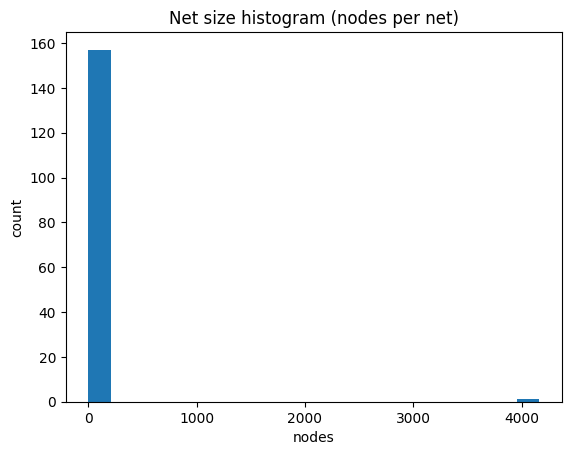

In [8]:
import json, collections
from pathlib import Path
from matplotlib import pyplot as plt

nets_path = Path(cfg.paths.processed)/"nets"/pdf_stem/"page-1.json"
nets = json.loads(nets_path.read_text(encoding="utf-8"))["nets"]
sizes = [n["nodes"] for n in nets]
plt.figure()
plt.hist(sizes, bins=20)
plt.title("Net size histogram (nodes per net)")
plt.xlabel("nodes"); plt.ylabel("count")
plt.show()

In [9]:
# Quick smoke-test without reclassifying everything:
from src.utils.io import read_json
from PIL import Image
from transformers import AutoProcessor
import torch, json

# Enable llava temporarily if present
try:
    local = cfg.models.llava_v16_mistral_7b.local_path
except Exception:
    local = None

if local:
    print("LLaVA available at:", local)
    processor = AutoProcessor.from_pretrained(local, trust_remote_code=True)
    try:
        from transformers import AutoModelForImageTextToText as ModelCls
    except Exception:
        from transformers import AutoModelForVision2Seq as ModelCls
    model = ModelCls.from_pretrained(local, torch_dtype=torch.float32, device_map=None, trust_remote_code=True)
    model.eval()

    # pick 3 meso tiles we already used
    tiles_idx = read_json(Path(cfg.paths.interim)/"tiles"/"tile_index.json")
    meso = [t for t in tiles_idx if t["scale"]=="meso"][:3]
    for t in meso:
        img = Image.open(t["path"]).convert("RGB")
        prompt = 'Classify the main electrical component visible. Return JSON: {"type":"...", "confidence":0.0}'
        messages=[{"role":"user","content":[{"type":"image","image":img},{"type":"text","text":prompt}]}]
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=[text], images=[img], return_tensors="pt")
        out_ids = model.generate(**inputs, max_new_tokens=128, do_sample=False)
        out = processor.batch_decode(out_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        s = out.find("{"); e = out.rfind("}")
        print(Path(t["path"]).name, "→", (json.loads(out[s:e+1]) if s!=-1 and e!=-1 else {"raw": out[-120:]}))
else:
    print("LLaVA not configured; skipping.")

d:\Anaconda\envs\diagram-intel\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LLaVA not configured; skipping.


In [10]:
# Will create processed/tables/<pdf>/page-1.json if something is detected
try:
    from src.vision.runners.table_reader import run_table_reader
    tstats = run_table_reader(cfg, pdf_stem, page=1)
    tstats
except Exception as e:
    print("table_reader not configured fully (ok to skip):", e)

table_reader not configured fully (ok to skip): run_table_reader() got an unexpected keyword argument 'page'


In [5]:
try:
    from src.graph.neo4j_adapter import push_page_graph
    pushed = push_page_graph(cfg, pdf_stem, page=1)
    print("Neo4j push:", pushed)
except Exception as e:
    print("Neo4j not configured or adapter skipped:", e)

Neo4j not configured or adapter skipped: cannot import name 'push_page_graph' from 'src.graph.neo4j_adapter' (D:\IIT BBS\Job Resources\fiolabs\diagram-intel\src\graph\neo4j_adapter.py)


In [5]:
from src.vision.runners.table_reader import run_table_reader
stats = run_table_reader(cfg, pdf_stem, page=1, top_k_tiles=8)
stats

d:\Anaconda\envs\diagram-intel\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-08-27 20:14:51.602 | INFO     | src.vision.runners.table_reader:run_table_reader:65 - [table_reader] found 0 tables → D:\IIT BBS\Job Resources\fiolabs\diagram-intel\data\_runs\dev-new-mods-1\processed\tables\wiring diagram_Main Distribution Panel_Fio Labs\page-1.json


{'count': 0,
 'path': 'D:\\IIT BBS\\Job Resources\\fiolabs\\diagram-intel\\data\\_runs\\dev-new-mods-1\\processed\\tables\\wiring diagram_Main Distribution Panel_Fio Labs\\page-1.json'}

In [9]:
# optional neo4j config
from omegaconf import OmegaConf
con = cfg.constraints
neo4j_yml = ROOT / "configs" / "neo4j.yaml"
if neo4j_yml.exists():
    con = OmegaConf.merge(con, OmegaConf.create({"neo4j": OmegaConf.load(neo4j_yml)}))

In [ ]:
import shutil
ws = Path(cfg.paths.processed).parents[0]  # data/_runs/dev-new-mods
print("Removing", ws)
shutil.rmtree(ws, ignore_errors=True)